Since the uprising of Artificial Intelligence, text classification has become one of the most staggering tasks to accomplish. In layman terms, We can say Artificial Intelligence is the field which tries to achieve human-like intelligent models to ease the jobs for all of us. We have an astounding proficiency in text classification but even many sophisticated NLP models are failed to achieve proficiency even close to it. So the question arises is that what we humans do differently? How do we classify text?

First of all, we understand words not each and every word but many of them and we can guess even unknown words just by the structure of a sentence. Then we understand the message that those series of words (sentence) conveys. Then from those series of sentences, we understand the meaning of a paragraph or an article. The similar approach is used in Hierarchical Attention model.

**To Learn Hierarchical Attention Network completely go [here](https://medium.com/@heetsankesara3/hierarchical-attention-networks-d220318cf87e)**

** Click [here](https://github.com/Hsankesara/DeepResearch/tree/master/Hierarchical_Attention_Network) to go to the code**


In [24]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from tensorflow.keras.layers import Layer, InputSpec

from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

In [25]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [26]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

def dot_product(x, kernel):
    """
    https://github.com/richliao/textClassifier/issues/13#issuecomment-377323318
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    
    Note: The layer has been tested with Keras 2.0.6
    
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    
    
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
    def get_config(self):
        base_config = super(AttentionWithContext, self).get_config()
        #base_config['output_dim'] = self.output_dim
        return base_config

### Attention Layer

### Config

In [27]:
max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2

### Data

In [28]:
from sklearn.utils import shuffle

In [29]:
df = shuffle(pd.read_json('E:/saves/News_Category_Dataset_v2.json', lines=True)).reset_index()

In [30]:
len(df.category.unique())

41

In [31]:
df.head()

,index,category,headline,authors,link,short_description,date
0,13995,WORLD NEWS,Iraqi Army Seizes Kirkuk From Kurds,,https://www.huffingtonpost.com/entry/iraq-army...,Baghdad isn't pleased with the region of Kurdi...,2017-10-16
1,24478,POLITICS,Comey Confirms Michael Flynn Under Investigati...,Paul Blumenthal,https://www.huffingtonpost.com/entry/comey-con...,The former FBI director said that possible per...,2017-06-08
2,76570,POLITICS,Chris Christie Asked To Leave Amtrak Quiet Car...,Igor Bobic,https://www.huffingtonpost.com/entry/chris-chr...,"No one is above the quiet car rules, governor.",2015-10-25
3,49781,POLITICS,Hillary Clinton Leads Donald Trump By 12 Point...,"Chris Kahn, Reuters",https://www.huffingtonpost.com/entry/clinton-t...,Clinton has led Trump throughout most of the 2...,2016-08-24
4,57380,QUEER VOICES,Caitlyn Jenner's Reality Show Pulled From The ...,Cavan Sieczkowski,https://www.huffingtonpost.com/entry/caitlyn-j...,"The cable company said it did it out of ""respe...",2016-05-31


In [76]:
df.category.unique()

array(['WORLD NEWS', 'POLITICS', 'QUEER VOICES', 'ENTERTAINMENT',
       'WELLNESS', 'HEALTHY LIVING', 'HOME & LIVING', 'MEDIA',
       'BLACK VOICES', 'GREEN', 'STYLE & BEAUTY', 'PARENTING', 'COLLEGE',
       'FOOD & DRINK', 'TECH', 'SPORTS', 'IMPACT', 'TRAVEL', 'COMEDY',
       'ARTS', 'CRIME', 'TASTE', 'WOMEN', 'BUSINESS', 'WORLDPOST',
       'PARENTS', 'WEDDINGS', 'DIVORCE', 'FIFTY', 'MONEY', 'WEIRD NEWS',
       'STYLE', 'GOOD NEWS', 'SCIENCE', 'RELIGION', 'EDUCATION',
       'ENVIRONMENT', 'LATINO VOICES', 'ARTS & CULTURE', 'CULTURE & ARTS'],
      dtype=object)

In [33]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [34]:
df['text'] = df['headline'] +'. ' +df['short_description']

In [35]:
df.head()

,index,category,headline,authors,link,short_description,date,text
0,13995,WORLD NEWS,Iraqi Army Seizes Kirkuk From Kurds,,https://www.huffingtonpost.com/entry/iraq-army...,Baghdad isn't pleased with the region of Kurdi...,2017-10-16,Iraqi Army Seizes Kirkuk From Kurds. Baghdad i...
1,24478,POLITICS,Comey Confirms Michael Flynn Under Investigati...,Paul Blumenthal,https://www.huffingtonpost.com/entry/comey-con...,The former FBI director said that possible per...,2017-06-08,Comey Confirms Michael Flynn Under Investigati...
2,76570,POLITICS,Chris Christie Asked To Leave Amtrak Quiet Car...,Igor Bobic,https://www.huffingtonpost.com/entry/chris-chr...,"No one is above the quiet car rules, governor.",2015-10-25,Chris Christie Asked To Leave Amtrak Quiet Car...
3,49781,POLITICS,Hillary Clinton Leads Donald Trump By 12 Point...,"Chris Kahn, Reuters",https://www.huffingtonpost.com/entry/clinton-t...,Clinton has led Trump throughout most of the 2...,2016-08-24,Hillary Clinton Leads Donald Trump By 12 Point...
4,57380,QUEER VOICES,Caitlyn Jenner's Reality Show Pulled From The ...,Cavan Sieczkowski,https://www.huffingtonpost.com/entry/caitlyn-j...,"The cable company said it did it out of ""respe...",2016-05-31,Caitlyn Jenner's Reality Show Pulled From The ...


In [91]:
df['text'][0]

"Iraqi Army Seizes Kirkuk From Kurds. Baghdad isn't pleased with the region of Kurdistan's emboldened attempts at independence."

In [77]:
df = df[['text', 'category']]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
text        200853 non-null object
category    200853 non-null object
dtypes: object(2)
memory usage: 3.1+ MB


In [176]:
categories = df['category']
text = df['text']

In [177]:
text

0         Iraqi Army Seizes Kirkuk From Kurds. Baghdad i...
1         Comey Confirms Michael Flynn Under Investigati...
2         Chris Christie Asked To Leave Amtrak Quiet Car...
3         Hillary Clinton Leads Donald Trump By 12 Point...
4         Caitlyn Jenner's Reality Show Pulled From The ...
                                ...                        
200848    Ahhhh, Weddings. Ok, so here are some things I...
200849    World's Wealthiest Billionaires Got Nearly $1 ...
200850    John Legend's Powerful NAACP Speech Highlights...
200851    Robert Plant, Big Freedia Rock: Good Day for G...
200852    Fish Market Buys Freedom For Fred The 70-Pound...
Name: text, Length: 200853, dtype: object

In [40]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 40
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int

In [41]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [42]:
paras = []
labels = []
texts = []

In [97]:
df.text.shape[0]

200853

In [44]:
df2 = pd.DataFrame(columns=['text'])

In [45]:
df2.insert(1,"text",'dddd')

ValueError: cannot insert text, already exists

In [46]:
df2

,text


In [47]:
df2 = pd.DataFrame([["welcome to florida"]], index = [["text"]])

In [48]:
df2

,0
text,welcome to florida


In [134]:
sent_lens = []
sent_nums = []
for idx in range(df.text.shape[0]):
    text = clean_str(df.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

In [108]:
sent_lens = []
sent_nums = []
for idx in range(1):
    text = clean_str(df.text[idx])
    print(text)
    texts.append(text)
    #print(texts)
    sentences = tokenize.sent_tokenize(text)
    print(sentences)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
        print(sent)
    paras.append(sentences)
    

iraqi army seizes kirkuk from kurds. baghdad isnt pleased with the region of kurdistans emboldened attempts at independence.
['iraqi army seizes kirkuk from kurds.', 'baghdad isnt pleased with the region of kurdistans emboldened attempts at independence.']
iraqi army seizes kirkuk from kurds.
baghdad isnt pleased with the region of kurdistans emboldened attempts at independence.


In [136]:
sent_lens

[6,
 12,
 10,
 14,
 13,
 9,
 11,
 10,
 10,
 12,
 14,
 15,
 5,
 8,
 20,
 7,
 9,
 15,
 9,
 22,
 7,
 5,
 12,
 1,
 7,
 24,
 16,
 6,
 6,
 8,
 10,
 4,
 8,
 20,
 9,
 12,
 8,
 9,
 15,
 7,
 31,
 10,
 9,
 12,
 8,
 12,
 11,
 23,
 9,
 26,
 12,
 11,
 8,
 12,
 20,
 15,
 15,
 6,
 18,
 13,
 9,
 8,
 20,
 12,
 49,
 7,
 11,
 10,
 3,
 22,
 10,
 9,
 22,
 11,
 13,
 11,
 27,
 10,
 6,
 29,
 13,
 13,
 5,
 27,
 6,
 38,
 5,
 27,
 10,
 6,
 4,
 7,
 17,
 13,
 6,
 3,
 9,
 12,
 26,
 7,
 17,
 11,
 11,
 7,
 12,
 11,
 9,
 9,
 21,
 8,
 13,
 9,
 27,
 9,
 21,
 12,
 23,
 8,
 14,
 9,
 23,
 28,
 14,
 15,
 6,
 6,
 14,
 4,
 40,
 13,
 14,
 8,
 14,
 11,
 13,
 9,
 14,
 8,
 10,
 14,
 10,
 5,
 16,
 17,
 4,
 19,
 11,
 3,
 2,
 4,
 37,
 9,
 16,
 5,
 3,
 8,
 1,
 2,
 14,
 12,
 25,
 7,
 9,
 9,
 22,
 16,
 24,
 9,
 28,
 3,
 13,
 22,
 12,
 19,
 9,
 23,
 13,
 20,
 12,
 17,
 8,
 15,
 7,
 16,
 13,
 4,
 12,
 20,
 11,
 4,
 3,
 15,
 14,
 13,
 8,
 6,
 7,
 13,
 9,
 10,
 21,
 12,
 7,
 10,
 8,
 26,
 5,
 3,
 26,
 20,
 12,
 26,
 26,
 6,
 19,
 6,
 5,
 11

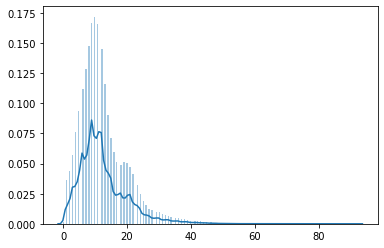

In [50]:
sns.distplot(sent_lens, bins=200)
plt.show()

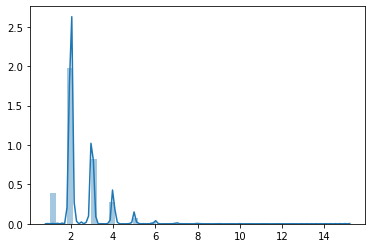

In [51]:
sns.distplot(sent_nums)
plt.show()

In [114]:
tokenizer

In [137]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [138]:
texts

['iraqi army seizes kirkuk from kurds. baghdad isnt pleased with the region of kurdistans emboldened attempts at independence.',
 'comey confirms michael flynn under investigation for lying to fbi. the former fbi director said that possible perjury is part of the criminal inquiry.',
 'chris christie asked to leave amtrak quiet car for talking on his phone. no one is above the quiet car rules, governor.',
 'hillary clinton leads donald trump by 12 points in new poll. clinton has led trump throughout most of the 2016 campaign',
 'caitlyn jenners reality show pulled from the air across africa. the cable company said it did it out of respect for viewers.',
 'nora ephrons lessons about love: 10 things the legendary writer and director taught us. had she not died of leukemia last summer, nora ephron would have turned 72 today. the universally loved writer, director',
 'cut salt, add potassium, live longer, researchers say. if people cut their salt intake and increased their intake of potassi

In [139]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

bob mcdonnell
— david
the hamilton creator
and its
at johansson
gratisography
but if
bob mcdonnell
— david
the hamilton creator
and its
at johansson
gratisography
but if


In [164]:
p=[55,6,8,12,3,54]
p[:-3]

[55, 6, 8]

In [166]:
y_train

,ARTS,ARTS & CULTURE,BLACK VOICES,BUSINESS,COLLEGE,COMEDY,CRIME,CULTURE & ARTS,DIVORCE,EDUCATION,...,STYLE & BEAUTY,TASTE,TECH,TRAVEL,WEDDINGS,WEIRD NEWS,WELLNESS,WOMEN,WORLD NEWS,WORLDPOST
198084,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
124409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
73111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
57655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
64797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [55]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 100266 unique tokens.


In [56]:
labels = pd.get_dummies(categories)

In [57]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (200853, 6, 40)
Shape of labels tensor: (200853, 40)


In [58]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']
[1211, 1082, 3630, 4763, 919, 4117, 2663, 806, 2784, 806, 12831, 1042, 1114, 4983, 1111, 2070, 5384, 3368, 2751, 891, 2244, 1391, 6905, 3124, 26240, 5055, 2041, 1731, 3927, 1845, 7707, 1694, 1684, 7879, 2931, 2121, 14295, 2810, 1745, 4988]
[298, 257, 898, 1174, 225, 1058, 742, 224, 642, 198, 3227, 281, 287, 1243, 287, 552, 1310, 827, 708, 238, 571, 316, 1772, 831, 6499, 1259, 515, 447, 957, 409, 1942, 402, 398, 2008, 720, 549, 3

### Model

In [59]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [60]:
import os

In [61]:
GLOVE_DIR = "E:/glove/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [62]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 27655 which is 27.58 % of total words


In [63]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [64]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(40, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [74]:
embedding_layer

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [ ]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [ ]:
#history = model.fit(x_train, y_train ,validation_data=(x_val, y_val), epochs=10, batch_size=512, callbacks=[checkpoint])

In [ ]:
#model.save('try2.h5')

## Plotting time

In [ ]:
#print(history.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model.save('han.h5')

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

def dot_product(x, kernel):
    """
    https://github.com/richliao/textClassifier/issues/13#issuecomment-377323318
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    
    Note: The layer has been tested with Keras 2.0.6
    
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    
    
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
    def get_config(self):
        base_config = super(AttentionWithContext, self).get_config()
        #base_config['output_dim'] = self.output_dim
        return base_config
   

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model

In [ ]:
from tensorflow.python import keras
print(keras.__version__)

In [189]:
from tensorflow.keras.models import load_model

model3=load_model('han.h5',custom_objects={'AttentionWithContext': AttentionWithContext})

In [345]:
a=model3.predict(x_train[:4])

In [346]:
a1=a[3]

In [347]:
a

array([[2.99271825e-08, 1.04938902e-09, 7.23678681e-07, 1.71067168e-05,
        3.19025787e-07, 2.08094025e-06, 1.89930383e-08, 1.50936121e-11,
        2.07704929e-07, 3.19916637e-07, 7.42233397e-07, 1.66133253e-12,
        1.79226174e-06, 4.73083239e-10, 1.03147768e-05, 9.68415392e-08,
        9.99609649e-01, 3.78926535e-09, 1.25569977e-06, 3.39165993e-08,
        2.12379110e-08, 1.99186029e-10, 2.19477229e-07, 2.76691775e-04,
        4.90402954e-07, 4.26189536e-06, 1.48986817e-06, 6.78193328e-06,
        2.92362938e-06, 2.50750190e-06, 1.31546880e-08, 1.49389251e-07,
        4.59329669e-07, 3.05223014e-10, 1.11795217e-07, 6.88019028e-08,
        9.73731630e-07, 5.31801197e-05, 1.31869946e-08, 4.92437630e-06],
       [4.72968823e-05, 1.49686386e-07, 9.25717934e-04, 7.29056701e-05,
        2.97672591e-06, 9.71111562e-03, 5.34704532e-06, 1.88423144e-08,
        3.33253820e-06, 2.09036557e-06, 6.53199758e-03, 1.32174760e-09,
        2.17330572e-03, 2.24701594e-07, 2.10179482e-03, 2.29083

In [348]:
b=np.amax(a1)

In [349]:
b

0.49089372

In [350]:
result = np.where(a1==b)

In [340]:
print(result)

(array([16], dtype=int64),)


In [327]:
p=x_train[:1]

In [328]:
p[0]

array([[ 8,  2,  9, 10,  3, 11, 12,  4, 13,  3, 14, 15, 16,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

In [219]:
y_train.columns

Index(['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE',
       'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS',
       'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES',
       'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES',
       'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE',
       'TECH', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS', 'WOMEN',
       'WORLD NEWS', 'WORLDPOST'],
      dtype='object')

In [168]:
df3

,text
0,NPR and First Phase of Census Postponed after ...
1,Spain buys medical equipment worth 432 million...


In [352]:
df3=pd.read_csv('news_list.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 38: invalid start byte

In [312]:
text1=df3['text']

In [313]:
df3['text']

0    NPR and First Phase of Census Postponed after ...
1    Why Jack Nicholson Gave Diane Keaton Money Aft...
2    Brad Pitt and Jennifer Aniston 'still together...
3    Brad Pitt and Angelina Jolie even hid secret l...
Name: text, dtype: object

In [314]:
sent_lens = []
sent_nums = []
paras1=[]
texts=[]
for idx in range(df3.text.shape[0]):
    text = clean_str(df3.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras1.append(sentences)

In [315]:
sentences

['brad pitt and angelina jolie even hid secret love on mr & mrs smith set from their bodyguard']

In [316]:
sent_lens

[13, 14, 11, 17]

In [317]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [318]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras1):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [310]:
word_index['bella']

12170

In [319]:
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#labels = labels.iloc[indices]
#nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:5]
#y_train = labels[:-nb_validation_samples]
#x_val = data[-nb_validation_samples:]
#y_val = labels[-nb_validation_samples:]
#print('Number of positive and negative reviews in traing and validation set')
#print(y_train.columns.tolist())
#print(y_train.sum(axis=0).tolist())
#print(y_val.sum(axis=0).tolist())

In [320]:
x_train

array([[[ 8,  2,  9, 10,  3, 11, 12,  4, 13,  3, 14, 15, 16,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,